In [4]:
import simulation_tools as sim_tools

import time

import pandas as pd
import numpy as np

from cmdstanpy import CmdStanModel
from IPython.display import display

In [5]:
# Remove cmdstanpy logs
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [6]:
num_repetitions = 2
prop_const = np.full(38, 0.5)
prop_varying = np.concatenate(
    (np.full(5, 0.5), np.linspace(0.5, 0.95, sim_tools.CHICK_NUM_EXPTS - 5))
)

In [7]:
def simulate_across_sigma_b(
    model,
    num_repetitions,
    num_subjects_per_expt,
    prop_treatment,
    mu_b,
    mu_theta,
    sigma_b_grid,
    sigma_theta,
    sigma_treatment,
    sigma_control,
    show_progress=False
):
    begin_time = time.time()

    summary_stats = {}
    for i, sigma_b in enumerate(sigma_b_grid):
        if show_progress:
            print(f"Sigma b: {sigma_b}. Run: {i + 1}/{len(sigma_b_grid)}")

        summary_stats[sigma_b] = sim_tools.repeat_inferences(
            model=model,
            num_repetitions=num_repetitions,
            num_subjects_per_expt=num_subjects_per_expt,
            prop_treatment=prop_treatment,
            mu_b=mu_b,
            mu_theta=mu_theta,
            sigma_b=sigma_b,
            sigma_theta=sigma_theta,
            sigma_treatment=sigma_treatment,
            sigma_control=sigma_control,
        )

    if show_progress:
        print(f"Took {time.time() - begin_time:.2f} seconds.")

    return summary_stats

In [8]:
def summary_stats_dict_to_df(summary_stats_dict):
    sigma_b_grid = list(summary_stats_dict.keys())
    estimators = list(summary_stats_dict[sigma_b_grid[0]].keys())
    statistics = list(summary_stats_dict[sigma_b_grid[0]][estimators[0]].keys())

    df = pd.DataFrame({
        "sigma_b": np.tile(sigma_b_grid, len(estimators)),
        "estimator": np.repeat(estimators, len(sigma_b_grid))
    })

    for statistic in statistics:
        df[statistic] = [
            np.array(summary_stats_dict[s][e][statistic]).mean()
            for s, e in zip(df["sigma_b"], df["estimator"])
        ]
        
    return df

In [9]:
def simulate_across_sigma_b_df(
    model,
    num_repetitions,
    num_subjects_per_expt,
    prop_treatment,
    mu_b,
    mu_theta,
    sigma_b_grid,
    sigma_theta,
    sigma_treatment,
    sigma_control,
    show_progress=False
):
    summary_stats = simulate_across_sigma_b(
        model=model,
        num_repetitions=num_repetitions,
        num_subjects_per_expt=num_subjects_per_expt,
        prop_treatment=prop_treatment,
        mu_b=mu_b,
        mu_theta=mu_theta,
        sigma_b_grid=sigma_b_grid,
        sigma_theta=sigma_theta,
        sigma_treatment=sigma_treatment,
        sigma_control=sigma_control,
        show_progress=show_progress
    )
    
    return summary_stats_dict_to_df(summary_stats)

In [10]:
df_const_p = simulate_across_sigma_b_df(
    model=CmdStanModel(stan_file="dynamic_hier.stan"),
    num_repetitions=num_repetitions,
    num_subjects_per_expt=np.repeat(
            sim_tools.CHICK_NUM_SUBJECTS_PER_EXPT, sim_tools.CHICK_NUM_EXPTS
        ),
    prop_treatment=prop_const,
    mu_b=0,
    mu_theta=sim_tools.CHICK_MU_THETA,
    sigma_b_grid=sim_tools.CHICK_SIGMA_B_GRID,
    sigma_theta=sim_tools.CHICK_SIGMA_THETA,
    sigma_treatment=sim_tools.CHICK_SIGMA_TREATMENT,
    sigma_control=sim_tools.CHICK_SIGMA_CONTROL,
    show_progress=True,
)

Sigma b: 0.0. Run: 1/11
Sigma b: 0.01. Run: 2/11
Sigma b: 0.02. Run: 3/11
Sigma b: 0.03. Run: 4/11
Sigma b: 0.04. Run: 5/11
Sigma b: 0.05. Run: 6/11
Sigma b: 0.06. Run: 7/11
Sigma b: 0.07. Run: 8/11
Sigma b: 0.08. Run: 9/11
Sigma b: 0.09. Run: 10/11
Sigma b: 0.1. Run: 11/11
Took 11.08 seconds.


In [11]:
# First 5 experiments use p=0.5
# the rest increase linearly from p=0.5 to p=0.95

prop_treatment_varying = np.concatenate(
    (np.full(5, 0.5), np.linspace(0.5, 0.95, sim_tools.CHICK_NUM_EXPTS - 5))
)
df_vary_p = simulate_across_sigma_b_df(
    model=CmdStanModel(stan_file="dynamic_hier.stan"),
    num_repetitions=num_repetitions,
    num_subjects_per_expt=np.repeat(
            sim_tools.CHICK_NUM_SUBJECTS_PER_EXPT, sim_tools.CHICK_NUM_EXPTS
        ),
    prop_treatment=prop_varying,
    mu_b=0,
    mu_theta=sim_tools.CHICK_MU_THETA,
    sigma_b_grid=sim_tools.CHICK_SIGMA_B_GRID,
    sigma_theta=sim_tools.CHICK_SIGMA_THETA,
    sigma_treatment=sim_tools.CHICK_SIGMA_TREATMENT,
    sigma_control=sim_tools.CHICK_SIGMA_CONTROL,
    show_progress=True,
)

Sigma b: 0.0. Run: 1/11
Sigma b: 0.01. Run: 2/11
Sigma b: 0.02. Run: 3/11
Sigma b: 0.03. Run: 4/11
Sigma b: 0.04. Run: 5/11
Sigma b: 0.05. Run: 6/11
Sigma b: 0.06. Run: 7/11
Sigma b: 0.07. Run: 8/11
Sigma b: 0.08. Run: 9/11
Sigma b: 0.09. Run: 10/11
Sigma b: 0.1. Run: 11/11
Took 12.55 seconds.


In [ ]:
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save df_const_p to a CSV file
df_const_p.to_csv(f"df_const_p_{timestamp}.csv", index=False)

# Save df_vary_p to a CSV file
df_vary_p.to_csv(f"df_vary_p_{timestamp}.csv", index=False)

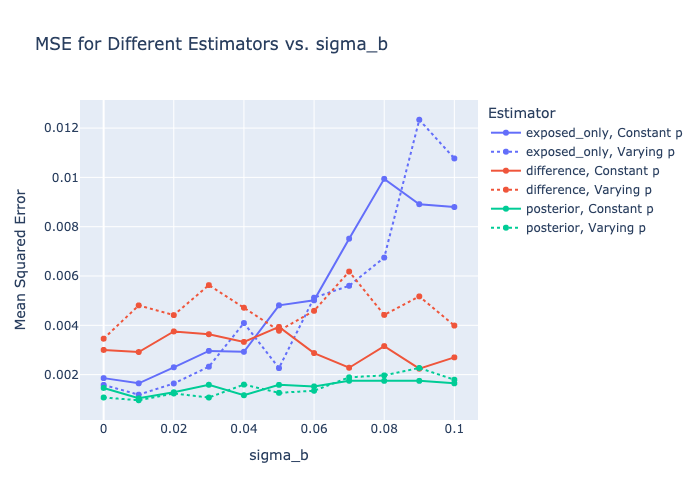

In [12]:
import plotly.express as px

# Create the plot using Plotly
fig_mse = px.line(
    pd.concat(
        [
            df_const_p.assign(LineStyle="Constant p"),
            df_vary_p.assign(LineStyle="Varying p"),
        ]
    ),
    x="sigma_b",
    y="mse",
    color="estimator",
    line_dash="LineStyle",
    markers=True,
    title="MSE for Different Estimators vs. sigma_b",
    labels={"sigma_b": "sigma_b", "mse": "Mean Squared Error"},
)

# Update the legend to remove linestyle
fig_mse.update_layout(legend_title_text="Estimator")

fig_mse.show("png")

In [13]:
print(df_vary_p[df_vary_p["estimator"] == "posterior"]["mse"].mean())
print(df_const_p[df_const_p["estimator"] == "posterior"]["mse"].mean())

0.0014974673351449386
0.0015038574593932352


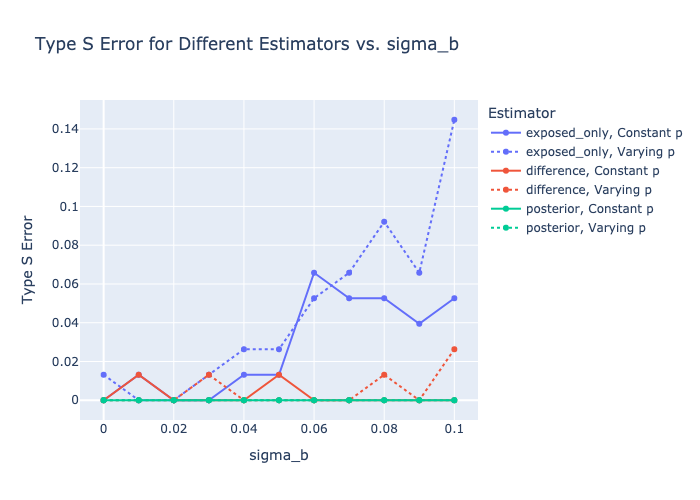

In [16]:
# Create the plot using Plotly
fig_type_s = px.line(
    pd.concat(
        [
            df_const_p.assign(LineStyle="Constant p"),
            df_vary_p.assign(LineStyle="Varying p"),
        ]
    ),
    x="sigma_b",
    y="type_s_rate",
    color="estimator",
    line_dash="LineStyle",
    markers=True,
    title="Type S Error for Different Estimators vs. sigma_b",
    labels={"sigma_b": "sigma_b", "type_s_rate": "Type S Error"},
)

# Update the legend to remove linestyle
fig_type_s.update_layout(legend_title_text="Estimator")

fig_type_s.show("png")

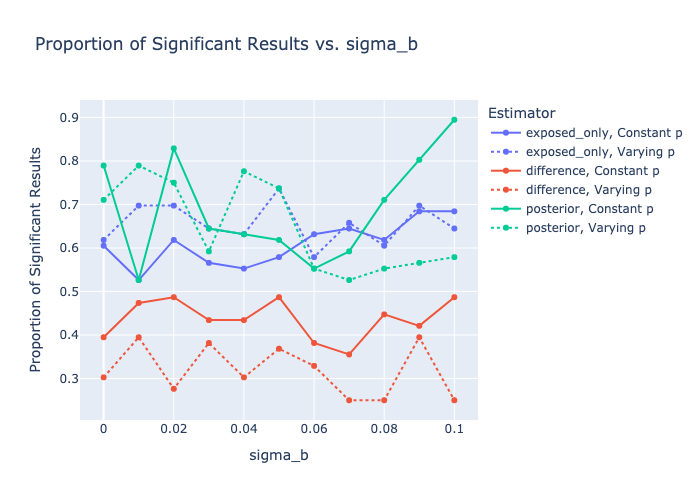

In [17]:
# Create the plot using Plotly
fig_prop_signif = px.line(
    pd.concat(
        [
            df_const_p.assign(LineStyle="Constant p"),
            df_vary_p.assign(LineStyle="Varying p"),
        ]
    ),
    x="sigma_b",
    y="prop_signif",
    color="estimator",
    line_dash="LineStyle",
    markers=True,
    title="Proportion of Significant Results vs. sigma_b",
    labels={"sigma_b": "sigma_b", "prop_signif": "Proportion of Significant Results"},
)

# Update the legend to remove linestyle
fig_prop_signif.update_layout(legend_title_text="Estimator")

fig_prop_signif.show("png")